In [53]:
import numpy as np 
import pandas as pd 
import os
import datetime

# lightgbm regressor
from catboost import CatBoostRegressor

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error

import optuna
import joblib


from typing import Optional,Dict,Tuple
from pathlib import Path

## Feature Engineering: DateTime Attributes

In [54]:
def extract_dt_attributes(df:pd.DataFrame, col: str):
    """
    Extract different Time-Series attributes from a pandas DataFrame with a datetime column
    """
    # convert datetime column, if not done already
    df[col] = pd.to_datetime(df[col])
    
    # dates and times
    df['date'] = df[col].dt.date
    df['time'] = df[col].dt.strftime('%H:%M:%S')
    
    #
    df['year'] = df[col].dt.year
    df['datediff_in_days'] = (
        df[col] - (df[col].min())
    ).dt.days
    
    # dictionary with time features as keys
    # and min and max as values
    time_features = {
        'hour': [0, 23],
        'dayofweek': [0, 6],
        'week': [1, 52],
        'month': [1, 12]
    }
    
    for c in time_features:
        if c=='week':
            df[c] = df[col].dt.isocalendar().week.astype(np.int32)
        else:
            df[c] = getattr(df[col].dt, c)
        
        
        ## sin and cosine features to capture the circular continuity
        col_min,col_max = time_features[c]
        angles = 2*np.pi*(df[c]-col_min)/(col_max-col_min+1)
        
        # add sin and cos
        df[c+'_sine'] = np.sin(angles).astype('float')
        df[c+'_cosine'] = np.cos(angles).astype('float')

## Lagged Variables
In the test data, information is given with a two days prior.  
We will need to lag by two days then.

In [55]:
def create_lagged_features(df: pd.DataFrame, lag: int) -> pd.DataFrame:
    """
    Create lagged features by shifting data in a pandas DataFrame.

    This function adds lagged features to the input DataFrame 'df' by shifting 
    the `data_block_id` column by the specified `lag` number of days. 
    It then merges the original DataFrame with the shifted DataFrame
    to create new columns for lagged features.

    params:
    ---------
    `df`: `pd.DataFrame` 
        The input DataFrame.
    `lag`: `int` 
        The number of days to shift the 'data_block_id' column.
    """
    df['data_block_id_shifted'] = df['data_block_id'] + lag
    df = pd.merge(
        df, 
        (df[['county', 'is_business','is_consumption',
             'product_type','data_block_id_shifted', 'time', 'target']].rename(
                columns={
                    'data_block_id_shifted':'data_block_id', 
                    'target':f'target_{lag}_days_ago'
                    }
                )   
        ),
    on = ['county', 'is_business','is_consumption','product_type', 'data_block_id', 'time'], 
    how='left'
    )
    # drop the redundant column
    df.drop(columns=['data_block_id_shifted'],inplace=True)
    return df

In [56]:
df_train = pd.read_csv('../../predict-energy-behavior-of-prosumers/train.csv', parse_dates=['datetime'])
df_train = df_train.dropna(how='any')
df_train.sort_values(by="datetime", inplace=True)
extract_dt_attributes(df_train, col="datetime")
df_train = create_lagged_features(df=df_train, lag=2)

df_client = pd.read_csv('../../predict-energy-behavior-of-prosumers/client.csv')

df_electricity = pd.read_csv('../../predict-energy-behavior-of-prosumers/electricity_prices.csv')
df_electricity["forecast_date"] = pd.to_datetime(df_electricity["forecast_date"])
df_electricity["origin_date"] = pd.to_datetime(df_electricity["origin_date"])
df_electricity['time'] = df_electricity['forecast_date'].dt.strftime('%H:%M:%S')

df_gas = pd.read_csv('../../predict-energy-behavior-of-prosumers/gas_prices.csv')
df_gas["forecast_date"] = pd.to_datetime(df_gas["forecast_date"])
df_gas["origin_date"] = pd.to_datetime(df_gas["origin_date"])

# merge with client data
df_train = pd.merge(
    df_train,
    df_client.drop('date', axis=1),
    on = ['data_block_id', 'product_type', 'county', 'is_business'],
    how='left'
)

# merge with electricity and gas prices forecasts data
df_train = pd.merge(
    df_train,
    df_electricity[['time', 'data_block_id', 'euros_per_mwh']],
    how = 'left',
    on = ['time', 'data_block_id'] 
)
df_train = pd.merge(
    df_train,
    df_gas[['data_block_id', 'lowest_price_per_mwh', 'highest_price_per_mwh']],
    how = 'left',
    on = ['data_block_id'] 
)

print(df_train.shape)

(2017824, 31)


In [57]:
df_train.columns

Index(['county', 'is_business', 'product_type', 'target', 'is_consumption',
       'datetime', 'data_block_id', 'row_id', 'prediction_unit_id', 'date',
       'time', 'year', 'datediff_in_days', 'hour', 'hour_sine', 'hour_cosine',
       'dayofweek', 'dayofweek_sine', 'dayofweek_cosine', 'week', 'week_sine',
       'week_cosine', 'month', 'month_sine', 'month_cosine',
       'target_2_days_ago', 'eic_count', 'installed_capacity', 'euros_per_mwh',
       'lowest_price_per_mwh', 'highest_price_per_mwh'],
      dtype='object')

Target variable is obviously highly correlated to itself two days before.  
What is interesting is, if we divide by type of target (Consumption=1, Production=0), we can see that consumption has a stronger correlation with itself two days prior. Production also shows a very strong correlation, but not as much as Consumption.  
This probably makes sense because
* consumption patterns are bound to habits a day-light cycles, and are influenced by the outside weather only to a certain extent (you probably don't change your habits about when to turn on the heating or the lights in your house in two-days time)
* Production patterns are actually bound to day-light cycles, cluod coverage, temperature, rain/snowfall and the weather in its complexity, which is more erratic than human habits

In [58]:
# correlation between target and target_2_days_ago
(
    df_train[['is_consumption', 'target', 'target_2_days_ago']]
    .groupby('is_consumption')
    .corr()
    .round(3)
)

target  target_2_days_ago
is_consumption                                             
0              target              1.000              0.822
               target_2_days_ago   0.822              1.000
1              target              1.000              0.946
               target_2_days_ago   0.946              1.000

Not sure how to interpret this correlations here

In [59]:
# correlation between target and additional features
(
    df_train[[
        'is_consumption', 'target', 
        # electricity prices
        'euros_per_mwh',
        # gas prices
        'lowest_price_per_mwh', 'highest_price_per_mwh',
        # client data
        'eic_count', 'installed_capacity'
    ]]
    .groupby('is_consumption')
    .corr()
    ['target']
    .unstack()
    .iloc[:, 1:]
    .round(3)
)

,euros_per_mwh,lowest_price_per_mwh,highest_price_per_mwh,eic_count,installed_capacity
is_consumption,,,,,
0,-0.018,0.012,0.009,0.340,0.357
1,0.018,-0.026,-0.023,0.336,0.809


## Baseline Model

In [60]:
not_feature_columns = ['datetime', 'row_id','prediction_unit_id','date','time']

X = df_train.drop(['target', 'data_block_id'] + not_feature_columns, axis=1)
y = df_train['target']

In [61]:
# unique year-month combinations -> to be used in cross-validation
timesteps = np.sort(np.array(
    pd.to_datetime(X[['year', 'month']].assign(day=1)).unique().tolist()
))
timesteps

array([Timestamp('2021-09-01 00:00:00'), Timestamp('2021-10-01 00:00:00'),
       Timestamp('2021-11-01 00:00:00'), Timestamp('2021-12-01 00:00:00'),
       Timestamp('2022-01-01 00:00:00'), Timestamp('2022-02-01 00:00:00'),
       Timestamp('2022-03-01 00:00:00'), Timestamp('2022-04-01 00:00:00'),
       Timestamp('2022-05-01 00:00:00'), Timestamp('2022-06-01 00:00:00'),
       Timestamp('2022-07-01 00:00:00'), Timestamp('2022-08-01 00:00:00'),
       Timestamp('2022-09-01 00:00:00'), Timestamp('2022-10-01 00:00:00'),
       Timestamp('2022-11-01 00:00:00'), Timestamp('2022-12-01 00:00:00'),
       Timestamp('2023-01-01 00:00:00'), Timestamp('2023-02-01 00:00:00'),
       Timestamp('2023-03-01 00:00:00'), Timestamp('2023-04-01 00:00:00'),
       Timestamp('2023-05-01 00:00:00')], dtype=object)

In [62]:
def fit_model(
    X:pd.DataFrame,
    y:pd.Series,
    config:Optional[Dict]=None,
    n_jobs:int=1,
    verbose:int=0
) -> CatBoostRegressor:
    """
    Trains a `CatBoostRegressor` with a L1 loss
    """
    model = CatBoostRegressor(
        n_estimators=100, 
        objective='MAE',
        thread_count=n_jobs,
        bootstrap_type =  "Bernoulli",
        sampling_frequency= 'PerTree',
        verbose=verbose,
        cat_features=['county', 'product_type'],
        leaf_estimation_iterations=1
    )
    
    if config:
        # if config is supplied, set the model hyperparameters
        model.set_params(**config)
        
    
    return model.fit(X,y)

In [63]:
def fit_and_test_fold(config:Dict, X, y, year_month_train, year_month_test) -> float:
    first_dates_month = pd.to_datetime(X[['year', 'month']].assign(day=1))
    
    train_index = first_dates_month.isin(year_month_train)
    test_index = first_dates_month.isin(year_month_test)
    
    X_train = X[train_index];X_test = X[test_index]
    y_train = y[train_index]; y_test = y[test_index]
    
    # fit model on training data
    model = fit_model(X_train, y_train, config, n_jobs=4)
    
    # generate predictions
    y_test_pred = model.predict(X_test)
    
    return mean_absolute_error(y_test, y_test_pred)

# loss function
def objective(trial):
    config = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.95,log=True),
        'depth': trial.suggest_int('depth', 3, 10, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg',1e-8,100,log=True),
        'model_size_reg': trial.suggest_float('model_size_reg',1e-8,100,log=True),
        'colsample_bylevel': trial.suggest_float("colsample_bylevel", 0.1, 1),
        'subsample': trial.suggest_float("subsample", 0.5, 1)
    }
    
    cv = TimeSeriesSplit(n_splits=3)
    cv_mae = [None]*3
    for i, (train_index, test_index) in enumerate(cv.split(timesteps)):
        cv_mae[i] = fit_and_test_fold(config, X, y, timesteps[train_index], timesteps[test_index])
        
    # saving the individual fold holdout metrics 
    # uncomment this line if you don't want this
    trial.set_user_attr('split_mae', cv_mae)
        
    return np.mean(cv_mae)


sampler = optuna.samplers.TPESampler(
    n_startup_trials=10, seed=1234
)

study = optuna.create_study(
    directions=['minimize'],
    sampler=sampler,
    study_name='catboost'
)

# maximum of 50 trials or 2 hr wall clock time
study.optimize(objective, n_trials=50, timeout= 7200) 
_ = joblib.dump(study, 'catboost_enefit_hyperopt.pkl')

[I 2023-11-11 23:21:01,888] A new study created in memory with name: catboost
[I 2023-11-11 23:21:29,815] Trial 0 finished with value: 101.25185644797455 and parameters: {'n_estimators': 78, 'learning_rate': 0.16996488374291047, 'depth': 5, 'l2_leaf_reg': 0.7138152748525242, 'model_size_reg': 0.6306059747250784, 'colsample_bylevel': 0.3453333447543775, 'subsample': 0.6382321275715483}. Best is trial 0 with value: 101.25185644797455.
[I 2023-11-11 23:22:53,667] Trial 1 finished with value: 116.92957519377278 and parameters: {'n_estimators': 171, 'learning_rate': 0.7851177877907137, 'depth': 9, 'l2_leaf_reg': 3.785931044085381e-05, 'model_size_reg': 0.001023178145374356, 'colsample_bylevel': 0.7151166416549227, 'subsample': 0.85635101349145}. Best is trial 0 with value: 101.25185644797455.
[I 2023-11-11 23:23:37,350] Trial 2 finished with value: 90.94295828509344 and parameters: {'n_estimators': 105, 'learning_rate': 0.12879261001607978, 'depth': 5, 'l2_leaf_reg': 1.3730441303373621e-08,

In [64]:
# get results
results = study.trials_dataframe(attrs=('number','value','duration', 'params'))
results = results.rename(columns={'value':'mae'})
results['duration'] = results['duration']/np.timedelta64(1, 's')
results = results.sort_values(by='mae',ascending=True)
results.to_csv(f'mae_catboost.csv',index=False)
results.head(10)

,number,mae,duration,params_colsample_bylevel,params_depth,params_l2_leaf_reg,params_learning_rate,params_model_size_reg,params_n_estimators,params_subsample
17,17,81.598619,44.882886,0.754308,7,0.000012,0.344028,87.113913,97,0.783999
47,47,81.970727,76.149529,0.932451,8,0.000867,0.145857,0.043368,163,0.677511
45,45,84.651289,69.276851,0.889386,8,0.000670,0.135444,0.044341,148,0.684151
44,44,85.899686,56.145307,0.856466,8,0.000361,0.148528,0.121072,121,0.669598
49,49,86.106725,72.879119,0.925395,5,0.000176,0.150917,0.058281,183,0.642381
42,42,86.623699,46.997750,0.825864,8,0.000821,0.172367,0.641681,95,0.750049
40,40,86.648809,62.591383,0.807083,9,0.000678,0.124215,3.201884,124,0.743338
36,36,87.196598,34.215071,0.765935,8,0.000050,0.399784,0.559794,68,0.756084
46,46,87.802351,62.178279,0.889451,6,0.008276,0.102098,0.149898,148,0.663723
27,27,87.997562,57.431416,0.551641,10,0.000002,0.192378,20.916321,111,0.767863


In [65]:
model = fit_model(X, y, n_jobs=4, config=study.best_params, verbose=20)

0:	learn: 243.8380914	total: 394ms	remaining: 37.8s
20:	learn: 81.2828299	total: 6.18s	remaining: 22.4s
40:	learn: 76.3345814	total: 11.8s	remaining: 16.1s
60:	learn: 68.3335513	total: 17s	remaining: 10s
80:	learn: 65.8939338	total: 22.4s	remaining: 4.42s
96:	learn: 64.2670275	total: 26.6s	remaining: 0us


In [66]:
# save model
model.save_model('catboost_energy_pred.cbm',format='cbm')

In [67]:
# Sanity check
y_pred = model.predict(X)
train_mae = mean_absolute_error(y, y_pred)
print(f'Train MAE: {train_mae:.3f}')

Train MAE: 64.267


<Axes: >

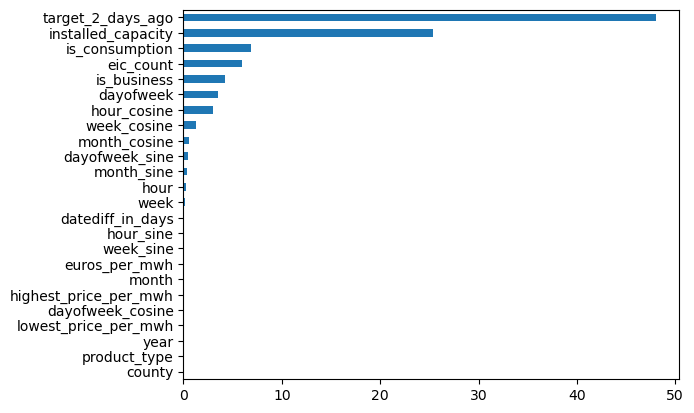

In [68]:
# gain based feature importances - not necessarily the most reliable
feat_imp = pd.Series(model.feature_importances_,X.columns).sort_values(ascending=True)
feat_imp.plot(kind='barh')

In [ ]:
def get_final_df(df, revealed_targets, client, electricity_prices, gas_prices):
    
    # get datetime features
    extract_dt_attributes(df)
    
    ### Target 2 days ago #### 
    revealed_targets = revealed_targets.rename(columns={'target':'target_2_days_ago'})
    revealed_targets['datetime'] = pd.to_datetime(revealed_targets['datetime']) + pd.Timedelta(days=2)
    df = pd.merge(
        df,
        revealed_targets[
            ['county', 'is_business','is_consumption','product_type', 'datetime', 'target_2days_ago']
        ],
        how='left',
        on=['county', 'is_business','is_consumption','product_type', 'datetime']
    )
    
    ### Electricity prices ####
    electricity_prices['forecast_date'] = pd.to_datetime(electricity_prices['forecast_date'])
    electricity_prices['time'] = electricity_prices['forecast_date'].dt.strftime('%H:%M:%S')
    electricity_prices['date'] = (electricity_prices['forecast_date'] + pd.Timedelta(days=1)).dt.date

    df = pd.merge(
        df, electricity_prices[['time', 'date', 'euros_per_mwh']],
        how = 'left',
        on = ['time', 'date'] 
    )
    
    ### Gas prices ###
    
    gas_prices['date'] = (pd.to_datetime(gas_prices['forecast_date']) + pd.Timedelta(days=1)).dt.date

    df = pd.merge(
        df, gas_prices[['date', 'lowest_price_per_mwh', 'highest_price_per_mwh']],
        how = 'left',
        on = ['date'] 
    )
    
    ### Client information ###
    client['date'] = (client['date'] + pd.Timedelta(days=2)).dt.date
    
    df = pd.merge(
        df, client,
        how='left',
        on = ['date', 'product_type', 'county', 'is_business'],
    )
    
    return df

## Submission on test set

In [ ]:
from 
env = enefit.make_env()
iter_test = env.iter_test()

for (test, revealed_targets, client, historical_weather,
        forecast_weather, electricity_prices, gas_prices, sample_prediction) in iter_test:
    
    test = test.rename(columns={'prediction_datetime':'datetime'})
    test = get_final_df(test, revealed_targets, client, electricity_prices, gas_prices)
    
    X_test = test.drop(not_feature_columns, axis=1)
    
    sample_prediction['target'] = model.predict(X_test)
    env.predict(sample_prediction)